<a href="https://colab.research.google.com/github/anishjohnson/Face-Emotion-Recognition/blob/main/FER/Colab%20Notebook/Face_Emotion_Recognition_Anish_Johnson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face Emotion Recognition**










# **Objective**
Our objective is to solve the above mentioned challenge by applying deep learning algorithms to live video data inorder to recognize the facial emotions and categorize them accordingly.

# **Dataset used**
We have utilized the [FER 2013](https://www.kaggle.com/datasets/msambare/fer2013) dataset provided on Kaggle.<br>
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.<br>

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

In [3]:
!nvidia-smi
!nvcc -V

Thu Mar 16 13:48:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.33       Driver Version: 528.33       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8     5W /  80W |   1273MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **Let's Begin:**

# **Data Exploration:**

**Lets start by importing the required libraries.**

In [1]:
# Basic python libraries.
import glob
import os.path as osp
import datetime
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import itertools
# Get rid of warnings!
import torchvision
from torchvision import models
import warnings
warnings.filterwarnings('ignore')
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.utils.data as data
import shutil
import time
from tqdm import tqdm
print('Above libraries have been imported.')

Above libraries have been imported.


**Perform some Data Augmentation on train and validations sets.**

# **Data Preprocessing:**

In [2]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale = (0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5), (0.5))
            ]),
            
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize((0.5), (0.5))
            ])
        }
        
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

In [3]:
resize = 48
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(resize, mean, std)

In [4]:
def make_datapath_list(phase='train'):
    rootpath = './dataset/'
    target_path = osp.join(rootpath + phase + '/**/*.jpg')
    print(target_path)
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
        
    return path_list

In [5]:
train_list = make_datapath_list('train')
val_list = make_datapath_list('val')

class MyDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase="train"):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('\\')[1]
        
        if label == "angry":
            label = 0
        elif label == "disgust":
            label = 1
        elif label == "fear":
            label = 2
        elif label == "happy":
            label = 3
        elif label == "neutral":
            label = 4
        elif label == "sad":
            label = 5
        elif label == "surprise":
            label = 6
        return img_transformed, label


train_set = MyDataset(train_list, transform = ImageTransform(resize, mean, std), phase = 'train')
val_set = MyDataset(val_list, transform = ImageTransform(resize, mean, std), phase = 'val')

index = 0
print(train_set.__len__())
print(train_set.__getitem__(index))

print(val_set.__len__())
print(val_set.__getitem__(index))

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size, shuffle = False)

dataloader_dict = {"train": train_loader, "val": val_loader}


batch_iterator = iter(dataloader_dict["train"])

batch = next(batch_iterator)


inputs, labels = batch

print("All data have been loaded!!")

./dataset/train/**/*.jpg
./dataset/val/**/*.jpg
28709
(tensor([[[-0.6314, -0.6392, -0.6706,  ...,  0.1686,  0.1137, -0.2157],
         [-0.6471, -0.6392, -0.6863,  ...,  0.1451,  0.1137, -0.2157],
         [-0.6157, -0.6549, -0.6941,  ...,  0.1294,  0.1216, -0.2157],
         ...,
         [-0.0039,  0.0824,  0.1216,  ..., -0.0510, -0.2863, -0.2627],
         [-0.0118,  0.0667,  0.1137,  ...,  0.0039, -0.2706, -0.2941],
         [-0.0353,  0.0039,  0.0824,  ...,  0.0431, -0.2235, -0.2941]]]), 0)
7178
(tensor([[[-0.6392, -0.7333, -0.7961,  ..., -0.9216, -0.8980, -0.8275],
         [-0.6078, -0.7804, -0.8353,  ..., -0.9137, -0.9216, -0.8353],
         [-0.6078, -0.7882, -0.8824,  ..., -0.8275, -0.8118, -0.8275],
         ...,
         [ 0.6314,  0.4039, -0.1529,  ...,  0.4980,  0.6078,  0.6000],
         [ 0.6627,  0.5529,  0.1686,  ...,  0.4196,  0.5686,  0.6000],
         [ 0.6314,  0.5765,  0.3412,  ...,  0.2941,  0.4118,  0.4824]]]), 0)
All data have been loaded!!


**Now lets create our custom CNN model.**

# **Build CNN Model:**

**Before we start building the neural network lets understand some of the terms that we will be using.**

* **Model = sequential** : A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

* **Padding** = The padding parameter of the Keras Conv2D class can take one of two values: 'valid' or 'same'. Setting the value to “valid” parameter means that the input volume is not zero-padded and the spatial dimensions are allowed to reduce via the natural application of convolution.

* **Activation** = relu :The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance.

* **Maxpooling** = Maximum pooling, or max pooling, is a pooling operation that calculates the maximum, or largest, value in each patch of each feature map. The results are down sampled or pooled feature maps that highlight the most present feature in the patch, not the average presence of the feature in the case of average pooling.

* **Batch normalization** = Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

* **Dropout** = Dropout is a technique used to prevent a model from overfitting. Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase.

* **Adam** = Adaptive Moment Estimation is an algorithm for optimization technique for gradient descent. The method is really efficient when working with large problem involving a lot of data or parameters. It requires less memory and is efficient. Intuitively, it is a combination of the ‘gradient descent with momentum’ algorithm and the ‘RMSP’ algorithm. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum.

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=7):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.maxpool = nn.AdaptiveMaxPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)


In [7]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=7, drop_rate=0.5):
        super(VGGNet, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),          
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),             
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
           
        )
        # self.flattened_tensor = nn.Flatten()
        self.avgpool = nn.AvgPool2d(7, stride=1)

        self.fc_layers = nn.Sequential(
            nn.Linear(2304, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(drop_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(drop_rate),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 7):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 256, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(256, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [14]:
from sklearn.svm import SVC
import numpy as np

label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model architecture
model_AlexNet = AlexNet(7).to(device)
model_VGGNet = VGGNet(7).to(device)
model_ResNet = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
    
# Load weights model
alex_checkpoint = torch.load('/dataset/best_model_alexnet.pth.tar')
vgg_checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/Project-AI/model_saved/pytorch_weights/best_model_vgg.pth.tar')
resnet_checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/Project-AI/model_saved/pytorch_weights/best_model_resnet.pth.tar')

model_AlexNet.load_state_dict(alex_checkpoint['model_state_dict'])
model_VGGNet.load_state_dict(vgg_checkpoint['model_state_dict'])
model_ResNet.load_state_dict(resnet_checkpoint['model_state_dict'])

y_pred_alex = []
y_pred_vgg = []
y_pred_resnet = []
y_true = []


with torch.no_grad():
    for inputs, labels in val_set:
        inputs = inputs.to(device)
        inputs = inputs.unsqueeze(0)

        outputs_alex = model_AlexNet(inputs)
        outputs_vgg = model_VGGNet(inputs)
        outputs_resnet =  model_ResNet(inputs)

        _, preds_alex = torch.max(outputs_alex, 1)
        _, preds_vgg = torch.max(outputs_vgg, 1)
        _, preds_resnet = torch.max(outputs_resnet, 1)

        y_pred_alex += preds_alex.tolist()
        y_pred_vgg += preds_vgg.tolist()
        y_pred_resnet += preds_resnet.tolist()
        y_true.append(labels)

y_pred_alex = np.array(y_pred_alex)
y_pred_vgg = np.array(y_pred_vgg)
y_pred_resnet = np.array(y_pred_resnet)

In [15]:
y_pred_alex_2d = y_pred_alex.reshape(-1,1)
y_pred_vgg_2d = y_pred_vgg.reshape(-1,1)
y_pred_resnet_2d = y_pred_resnet.reshape(-1,1)

In [16]:
print( y_pred_alex)

[0 1 1 ... 5 3 3]


In [19]:
# Concatenate the predictions along the first axis
combined_pred = np.concatenate((y_pred_alex_2d, y_pred_vgg_2d, y_pred_resnet_2d), axis=1)

# Flatten the labels array
labels = y_pred_alex  # Use the predictions from AlexNet as labels
# Fit the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(combined_pred, labels)

SVC(kernel='linear')

#Save model

In [20]:
import pickle
with open('model.pkl','wb') as f:
    pickle.dump(svm_model,f)


# **Model evaluation:**

In [21]:
# Load the SVM model
with open('/content/model.pkl', 'rb') as f:
    svm_loaded = pickle.load(f)


In [25]:
svm_pred = svm_loaded.predict(combined_pred)

# Convert the SVM predictions to numeric labels
y_pred = svm_pred

<Figure size 432x288 with 0 Axes>

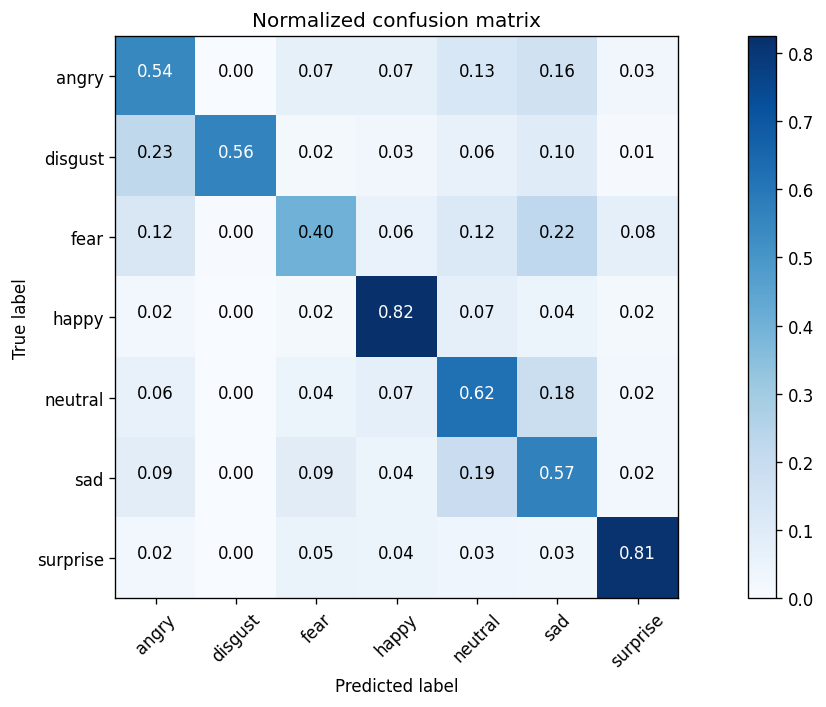

In [26]:
import numpy as np
import torch
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Create function to plot confusion matrix.
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12,6), dpi=120)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

#Load model and predict